# Preliminary work
The session showcases how to infer activities of transcription factor from single cell RNA-seq data and spatial transcriptomics data using three method. Please follow this notebook after you have [set up the environment](https://github.com/osmanbeyoglulab/Tutorials-on-ISMB-2024?tab=readme-ov-file#environment-set-up).

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")

## Downloading datasets
The following datasets will be used for demonstration, which can be downloaded via `scanpy` to the directory `data`.

In [2]:
sc.datasets.pbmc3k()

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [3]:
sc.datasets.pbmc3k_processed()

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We will use two ST datasets for demonstration of STAN.

In [4]:
sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
sc.datasets.visium_sge(sample_id="Parent_Visium_Human_Glioblastoma")

AnnData object with n_obs × n_vars = 3468 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## decoupleR
[decoupler](https://doi.org/10.1093/bioadv/vbac016) is a package containing different statistical methods to extract biological activities from omics data within a unified framework, including pathway activity inference and transcription factor activity inference. We follow [the instruction](https://decoupler-py.readthedocs.io/en/latest/installation.html) to install decoupler.

In [6]:
pip install decoupler


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip3.8 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import decoupler
decoupler.__version__

'1.5.0'

## pySCENIC (optional)
[pySCENIC](https://www.nature.com/articles/s41596-020-0336-2) is a package containing different statistical methods to extract biological activities from single-cell RNA-seq data within a unified framework, including gene regulatory network inference and transcription factor activity inference. We follow [the instruction](https://pyscenic.readthedocs.io/en/latest/installation.html) to install pySCENIC. pySCENIC depends on packages e.g. arboreto and ctxcore. **To install and use pySCENIC, we recommend to create a new conda envorinment as instructed.**

In [ ]:
pip install pyscenic

In [ ]:
import pyscenic
pyscenic.__version__

### Downloading resources and databases

In [ ]:
!mkdir resources_pyscenic
!curl https://resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt \
    -o resources_pyscenic/allTFs_hg38.txt
!curl https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
    -o resources_pyscenic/motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl
!curl https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
    -o resources_pyscenic/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
!curl https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
    -o resources_pyscenic/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather

## STAN
[STAN](https://www.biorxiv.org/content/10.1101/2024.06.26.600782v1) is a computational framework for inferring spatially informed transcription factor activity across cellular contexts. Specifically, STAN is a linear mixed-effects computational method that predicts spot-specific, spatially informed TF activities by integrating curated TF-target gene priors, mRNA expression, spatial coordinates, and morphological features from corresponding imaging data. We install additional packages to support STAN.

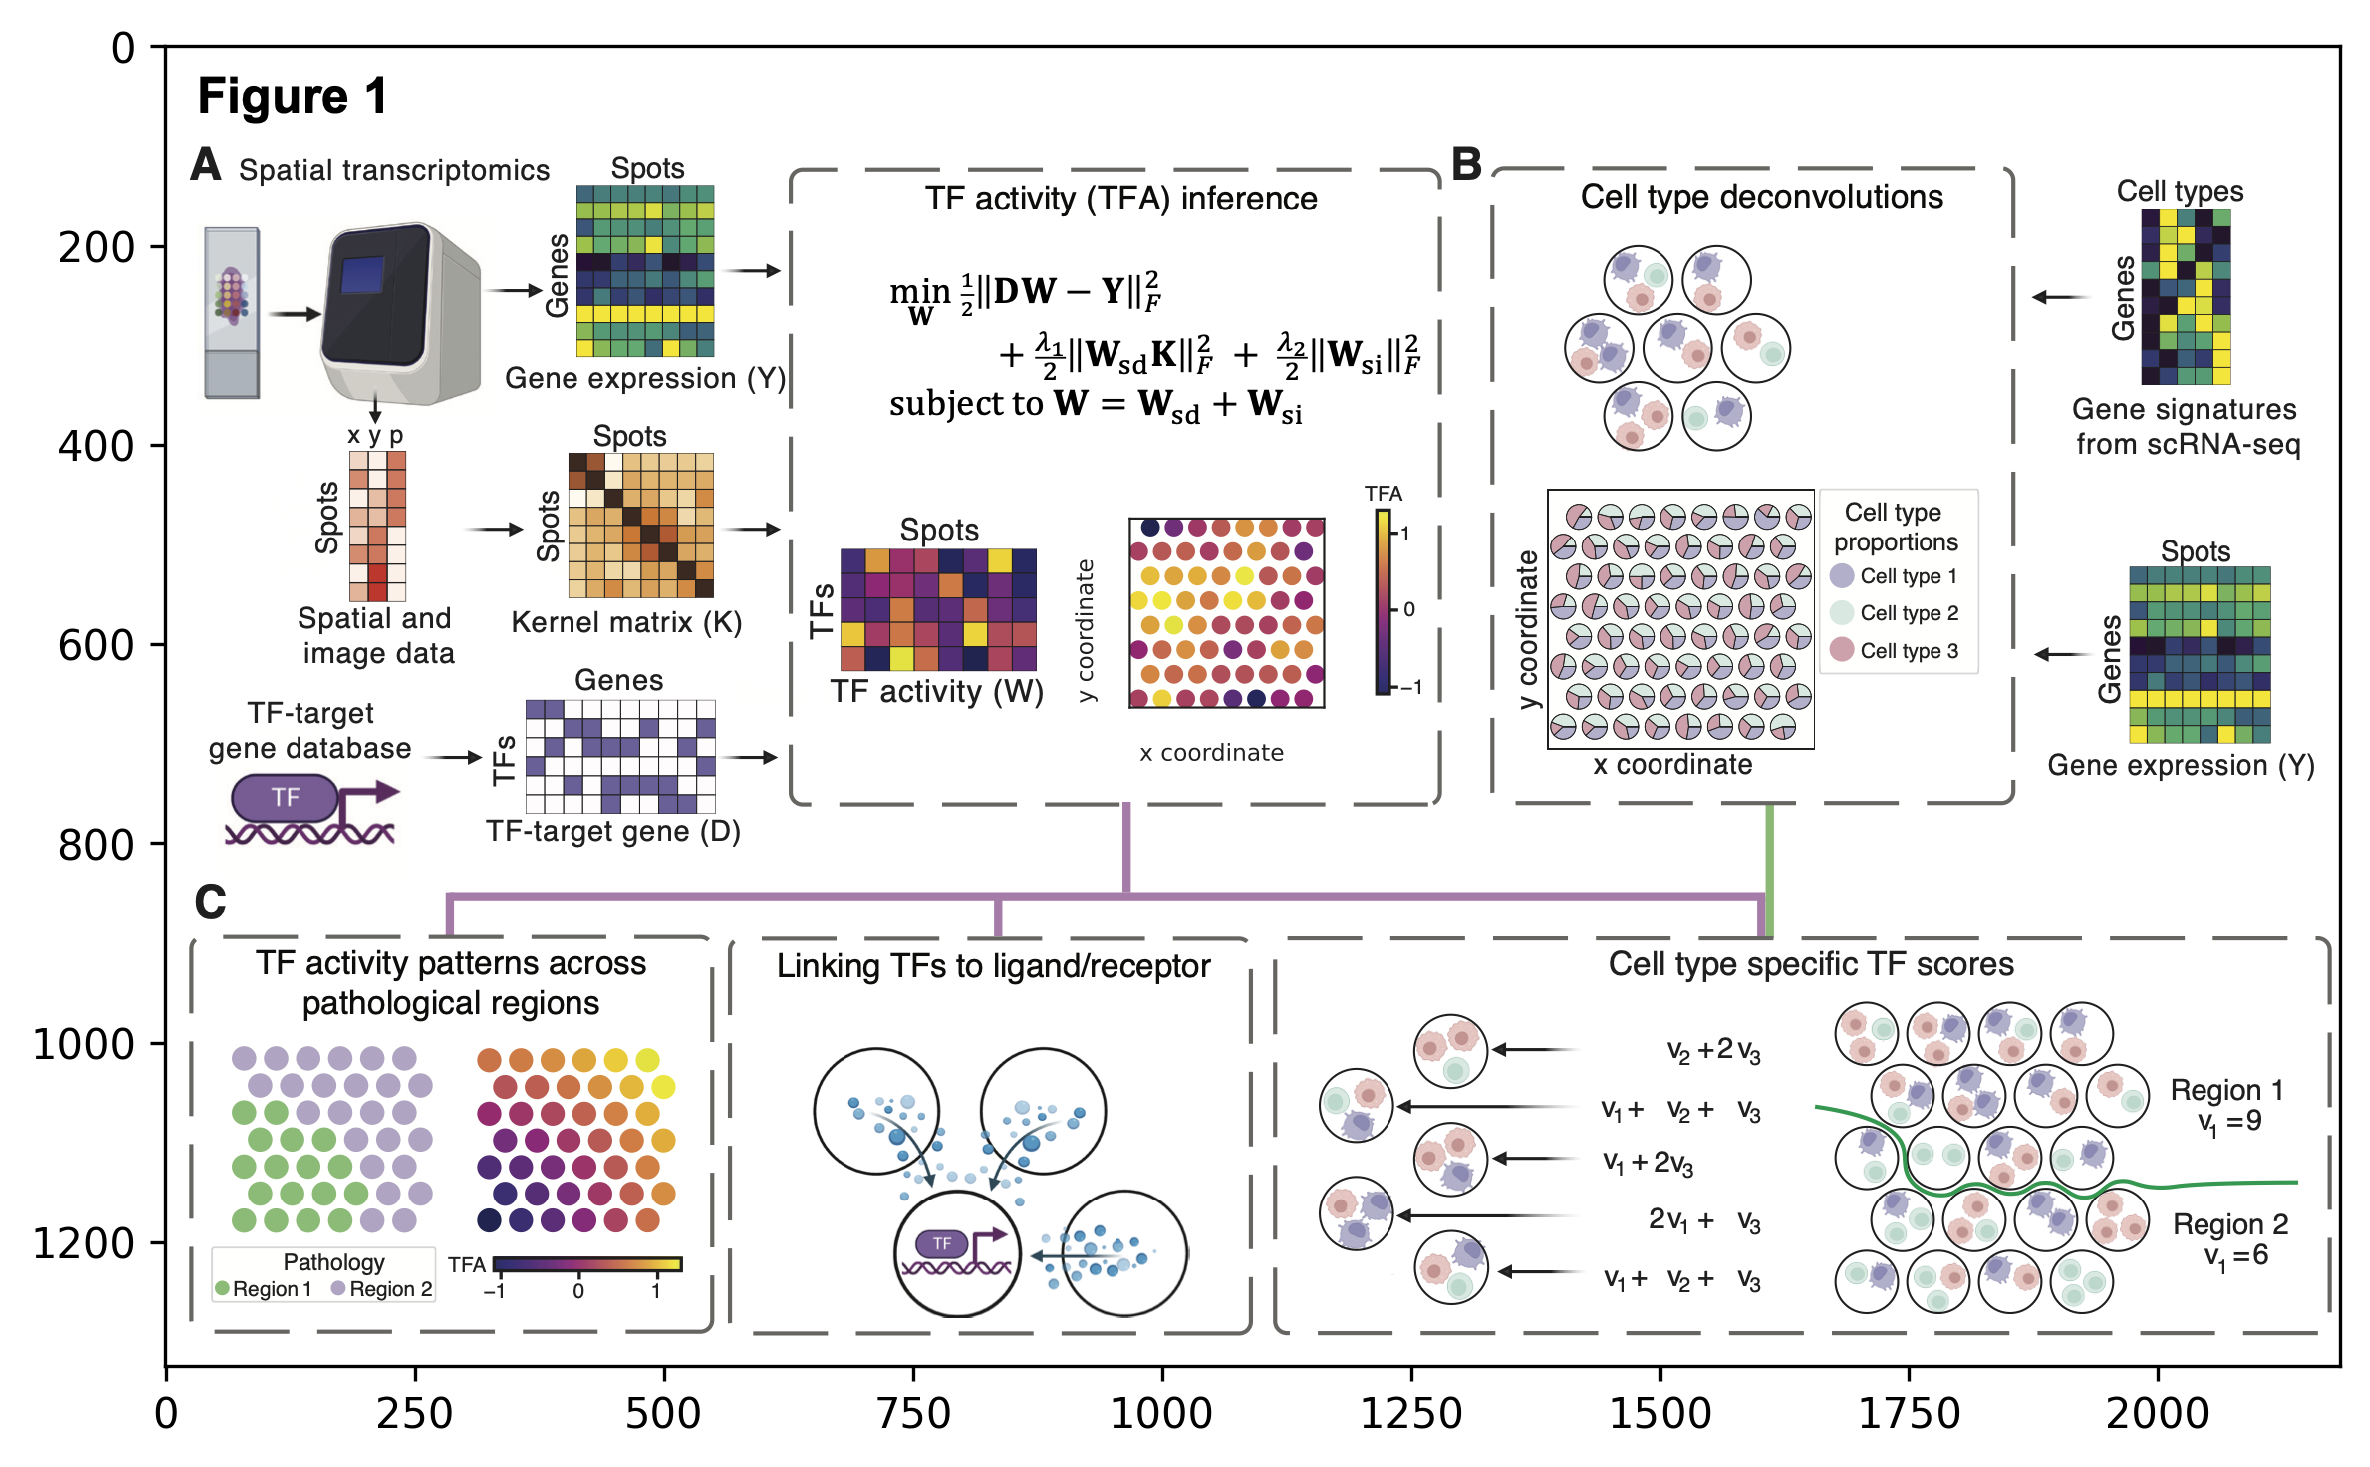

In [8]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
im = plt.imread('resources_stan/stan.png')
ax.imshow(im, interpolation='nearest')
plt.tight_layout()

### Downloading supporting files

In [ ]:
!mkdir resources_stan
!curl https://raw.githubusercontent.com/vitkl/cell2location_paper/1c645a0519f8f27ecef18468cf339d35d99f42e7/notebooks/selected_results/lymph_nodes_analysis/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/W_cell_density.csv \
    -o resources_stan/W_cell_density.csv
!curl https://raw.githubusercontent.com/vitkl/cell2location_paper/1c645a0519f8f27ecef18468cf339d35d99f42e7/notebooks/selected_results/lymph_nodes_analysis/CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001/manual_GC_annot.csv \
    -o resources_stan/manual_GC_annot.csv

In [9]:
import session_info
session_info.show()